#### by Stephen Gou
#### Nov 12, 2018
#### Student Number: 1000382908

# Introduction

A movie's box office is the most common metric to gauge its success. A good prediction of the revenue of a movie can guide production companies for building successful movies, and inform investors to pick out the most profitable movies. This project builds a model that predicts a movie's total revenue, given certain traits and facts about the movie. Only movies produced in the United States from 1990 to 2016 are considered, because the entertainment industry and economy changes over time. Movies produced after 2016 are not considered, because they have not reached their full total revenue potential. Only movies produced in the U.S are considered, because the market characteristics vary over countries and modelling of this aspect is beyond the scope of this project. This project aims to provide an effective prediction as soon as the movies are released, which means that data like opening weekend box office, IMDb rating, and social media sentiments cannot be used as features in the models.
     
To build an effective predictive model and gain insight, the project first explores and analyzes the major factors that might affect a movie's revenue. And then, several models of various types will be explored and trained. Its performance will be analyzed and compared to a baseline score. Last but not least, the models' limitations and potential improvements will be discussed.
    
# Data Collection
This project makes use of several sources to collect data for analysis and training. Various types of data are collected that includes movie's revenue, budget, meta-data, cast, crews, rankings of actors and actresses and so on. The detail of all the datasets used is listed below.

1) TMDB 5000 Movies dataset. This is the main dataset which provides budget, revenue, runtime, genre, release-date and production country data. Source: https://www.kaggle.com/tmdb/tmdb-movie-metadata

2) New York Times Review dataset. This dataset includes data like whether a movie was picked by NYT critics, and review summaries. Source: NYT API

3) New York Times Review Articles sentiment data. This dataset includes the sentiment polarity score (from -1 to +1) for each movie. The articles were scraped from NYT movie reviews by BeautifulSoup. The sentiment polarity score was computed using the TextBlob library for NLP.

4) TMDB 5000 Crew dataset. This dataset has detailed cast and crew information, ranging from actor to writer, for each movie. Source: https://www.kaggle.com/tmdb/tmdb-movie-metadata

5) Top actors ranking data. This a Top 1000 Actors/Actresses Ranking published on IMDb. Source: https://www.imdb.com/list/ls058011111/

6) Top directors ranking data. This a Top Directors of All Time Ranking released published on IMDb. Source: https://www.imdb.com/list/ls006136043/

7) Annual CPI. This dataset lists the annual average CPI for U.S. Source: UsInflationCalculator.com

## Data Cleaning
- Movies produced before 1990 and after 2016 were discarded. 
- Movies produced outside of U.S were discarded. 
- Movies with have zero revenue or budget, which might be a result of missing data or unreleased movie, were  removed.
- Movies that do not have sentiment polarity score were assigned neutral score (0), after normalization.


# Feature Selection and Transformation
There are a large amount of factors that might affect a movie's revenues ranging from movies' meta-data, to unemployment rate of the release year. Features that will be analyzed and incorporated into the predictive model are selected based on availability, informativeness, unambiguity, and interpretability. According to this criteria, the following features are selected: budget, runtime, critics-pick, genres, MPAA-rating, cast, and director. The following procedures and transformations of data are done to make data representable for modelling and to increase accuracy.

1) The cast of a movie is represented by a popularity score, which is calculated by the following rule. A percentile rank score for each cast is calculated according to the actors rank dataset. Then use 1 - percentage rank as the popularity score for a cast. So 1 is the highest one can get and 0 is the lowest (0 if cast not in the ranking). Then the cast popularity for the movie is calculated as following:
$$ Cast\ Popularity\ Score = \sum_{i}^{N} \gamma ^ i (1 - Percentile Rank (Cast\ i)) $$ where gamma is a decay factor and N is the number of casts.

2) The director is represented by a popularity score, which is calculated by the following rule. A percentile rank score is calculated according to the directors rank dataset. Then use 1 - percentage rank as the popularity score. So 1 is the highest one can get and 0 is the lowest (0 if director not in the ranking).

3) The revenue and budget are adjusted for inflation according to the rule: $$ adjusted = \frac{CPI(2017)}{CPI(release  \,year)} * unadjusted. $$

4) Genres are converted by one-hot encoding. Note that a movie can have multiple genres associated with it.

5) MPAA ratings are converted by one-hot encoding.

6) Runtime represented by a number and unchanged.

7) Critics pick is represented by 1 or 0 (1 repesents being picked)

8) New York Times review sentiment is represented by a polarity score. Negative score means negative sentiment and vice versa. The distribution of polarity scores of review articles have a positve mean. As a result, they are normalized to be more interpretable. For example, a negative score would mean that the review is more negative than the average sentiment polarity of all review articles.

# Exploratory Data Analysis
Some observations can be made from the statistics of our wrangled dataset. 
- There are 2,009 movies in our final dataset. 
- 14% of the movies are picked by the critics. 
- Average runtime of a movie is 108 minutes while the lengthiest runs more than 4 hours, the shortest runs 46 mintues.
- More than 66% of the movies are at least rated PG-13.
- The most common genres are Drama, Comedy, and Action.

## Distributions of Data
![](Images/revenue_dist.png)

![](Images/budget_dist.png)

Both revenue and budget have wide range of values and high positive skewness. Therefore, a log transformation were applied before modelling.

![revenue and budget](Images/revenue_budget_boxplot.png)

Both revenue and budget have large number of outliers. Revenue has outliers with more extreme values.


## Correlations Between Features
A heatmap of correlation between features is plotted to spot features that have strong relationships with each other, so that redundant features can be discarded to reduce multicollinearity.

![](Images/corr_heatmap2.png)

- Genres and mpaa-rating tend to have strong correlations. From the plot, it's clear that movies that have "family" as a genre is also very likely to have "animation" as a genre as well. Family and animation movies also usually have PG or G rating. 

- The quality of the cast appear to be uncorrelated with most of the genres of movies except for horror, where quality of cast drops significantly.

- Intuitively, the runtime of a movie has correlations with its genres, which is confirmed by the heatmap. The runtime also correlates with budget and quality of director and cast. 

- New York Time's critics' picks appear to be uncorrelated with most of the features of a movie, meaning that critics do not favor particular types of movies over the others. Action and thriller movies are marginally less likely to be picked, but that could just be a result of noise.

From these observations, runtime and mpaa-rating of a movie could be potentially discarded, because they usually depend on other features of the movie.

## New York Times Critics Pick and Review Sentiment
A regression of the normalized sentiment polarity score based on critics picks gives a extremely small p-value, and coefficient of 0.25. This means that critics pick does have some amount of effects on the sentiment of their review article, but the effects are very small. Since they do not show strong collinearity, both are kept as features.


# Analysis and Modelling
Since the goal is to predict revenue, a continuous value over a wide range, regression models are considered. More specifically, OLS regression, Regression Tree, k-Nearest-Neibours Regressor and Multilayer Perceptrons are the candidate models. 

## Model Performance Evaluation
The wrangled dataset is split into 70% training and 30% testing.

Initially, the models' performance are evaluated based on the R-Squared statistic and the residual plot.
An OLS regression model that simply includes all the features without adding higher order terms and interactions is fitted and its result is used as a baseline. 

It obtained a __R-Squared score of 0.492__ on the test set and the residual plot as below:
![](Images/baseline_residual1.png)

However, the R-Squared statistic is not very informative. Revenue is an unbounded number with high variance in nature, and there is a large number of outliers in the dataset. Moreover, the residual plot displays a clear linear relationship between residual and the revenues of the movies, meaning that there is a significant pattern of revenues of movies that it is not explained by the features. However, there is inherently large uncertainly of movie's revenue and given limited information there are about the movies. It's necessary to find a more effective metric to evaluate the models.

The alternative metric is defined as the percentage of predictions that are within 20% error from the true value when converted back to normal scale from log scale. It will be referred to as "accuracy". The baseline is __61.6%__, which is obtained by simply use the mean revenue for every prediction.

## OLS Linear Regression

The following steps are taken to improve the performance, interpretability and reduce overfitting.

* Like suggested in EDA, mpaa-rating is discarded because it depends on other features.

* Genres are discarded as well. OLS regression shows an extremely large condition number (> 10^ 10) with genres included, meaning there are strong multi-collinearity. In addition, it caused certain terms to have extremely large weights, even when L1/L2 reguarizers are added. Lastly, in introduced too many potential interactions between each other and other features like directors, actors and budget.

* Naturally removing outliers from dataset was considered, but removing them did not improve any model's performances. Therefore, outliers are kept.

* A brute force model that includes a large number of interactions between between features, and certain second order terms (102 total terms in regression formula) is fitted. However, it did not improve model accuracy.

The resulting formula for regression is $$revenue = Intercept + w_0 * runtime + w_1 * budget + w_2 * \text{critics pick} + w_4 * \text{cast score} + w_5 * \text{director score} + w_6 * \text{sentiment polarity} + w_7 * \text{sentiment polarity * budget}$$

![](Images/best_linear_ols.png)

It achieved an accuracy of __61.5%__, which is almost identical to the baseline accuracy by just predicting the mean of log revenue. Therefore, this linear model did not offer much explaining power. However, the analyzing the coefficeitns of the model does provide some insight into how the features affect revenue.
Budget, cast score, director score, and critics all have coefficients with significant p-values, but small coefficients. Runtime doesn't have a coefficient with extremely large p-value. Simply including sentiment polarity will produce a non-sigfinicant coefficient, but including interaction between sentiment polarity and budget result in significant coefficients. It means that positive sentiment polarity itself might not increase revenue, but it does have an effect if the budget of the movie is big.



## Non-Linear Regression Models
Given the large number of potential interactions and non-linear relationship between certain features and revenue, it is extremely hard manually select features. Thus, non-linear models like regression tree and multilayer perceptron (neutral networks with only fully connected hidden layers) are considered. For these models, all available features are included in the input. Hyper parameters were tuned by informal search based on their performance in a 5-fold cross-validation test.

__Input Features__: budget(log transformed), runtime(in minutes), critics pick(0-1), sentiment polarity score, genres(one-hot encoded), mpaa rating(one-hot encoded), cast score, director score.

### Regression Tree
A regression tree with max depth of 5 achieved accuracy of __63.3%__ and R-Squared of __0.387__. 
![](Images/tree_residual.png)
The top left section of the tree is shown as below:
![](Images/tree_viz.png)

Budget appears to provide the most information gain, as it's the root of the tree and it appears most frequently in top layers. More interestingly, certain genres, for example drama, and comedy provide considerable information gain. For example, in the graph above, there is a path that can be interpreted as the following: for a low-medium budget drama movie, if it has poor cast (cast score < 0.085), it only averages revenue of \\$ 1,088,930, otherwise it averages \\$ 16,826,740.

### kNN
A kNN model with k=5 obtained achieved accuracy of __61.4%__ and R-Squared of __0.336__.
![](Images/knn_residual.png)


### Neural Network
A neural network with two fully connected hidden layers, each of size 64 with ReLU activations, was trained for 2,000 iterations multiple times. The best network achieved accuracy of __74.2%__ and R-Squared of __0.392__.

![](Images/mlp_residual.png)

The neural network achieved the best prediction accuracy out of all the other models by a wide margin, and beat the baseline by 13%. The residuals are more evenly distributed and have less linear downward trend, comparing to that of other models. It suggests that the neural
network is able to capture the relationship between features and revenue better.


# Results
The project built a model (Multilayer-Perceptron), that is able to predict the lifetime revenue of a modern American movie within a 20% error margin __74.2%__ of times. To build the model, the project constructed a dataset of American movies produced between 1990 and 2016 that include features: budget, runtime, NYT critics pick, review sentiment polarity, genres, mpaa_rating, cast_score, and director_score. 

Other models including OLS linear regression, regression tree, and k-Nearest-Neighbours were exmained and trained, but did not achieve better result than baseline.

The OLS regression model shows that budget, cast score, director score, and critics all have coefficients with significant p-values, but small coefficients. Sentiment polarity score has more influence when budget of the movie is higher.

While the regression model failed to beat the baseline, neural network outperformed it by a 13% margin. This suggests that the features in our dataset do have correlations with the revenue but wasn't captured by the regression model. The reason could be that non-linear relationships, higher order terms of the features or complicated multi-way interactions between features were not accurately included in the OLS regression model.

# Limitations
The models were trained only on data of American movies produced between 1990 and 2016. It will not apply to movies produced in other countries, and or too far from this time period into the future. The model cannot predict the revenue before the release of a movie because it utilizes the critics picks and movie review sentiments, which are usually only available after release.

# Future Work
### Find better feature data
Since the residual shows that there is a significant linear pattern for the revenues was not explained by the model, more relevant data and data that have more explaining power might be explored and incorporated into the models. For example, the number of views of movie's trailers before release, social media influence of casts, writer of the movie, production company, season and so on. Another possibility is to loosen the assumption so that more post-release data can be incoporated like opening weekend box office, IMDb rating, hashtag counts and so on.

### Improve existing features
There are room for improvements of the features currently used in the models. For example, how the cast and director score is calculated could be improved. Instead of rank based, one could include more revenue related traits for example, actors' social media following, revenues of their past 3 movies, and so on.

### Improve modelling
Since the models are systemically predicting overestimated revenue for low revenue movies and underestimated revenue for high revenue movies, there might be opportunity to take advantage of this observation. For example, use locally weighted regression or an ensemble of models so that movies in differernt levels can be modelled separately.

## Python Code

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; 
from pandas.io.json import json_normalize
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn import tree

### Cleaning and Feature Mapping

In [2]:
github_raw_root = 'https://raw.githubusercontent.com/gouzhen1/Moives-Data-Analysis/master/Datasets/'

#NY Reviews Dataset
ny_df = pd.read_csv(github_raw_root + 'NY_movie_reviews.csv')
ny_df.rename(columns={'display_title':'title'},inplace=True)
ny_df = ny_df[['title','mpaa_rating','critics_pick']]

ny_sentiment_df = pd.read_csv(github_raw_root + 'ny_reviews_sentiment.csv')[['title','sentiment_polarity']]
ny_sentiment_df['sentiment_polarity'] = (ny_sentiment_df['sentiment_polarity'] - ny_sentiment_df['sentiment_polarity'].mean())/ny_sentiment_df['sentiment_polarity'].std()

#Wrangle actors and director
#TMDB Credits Dataset (for cast and director)
tmdb_credits_df = pd.read_csv(github_raw_root + 'tmdb_5000_credits.csv')
actors_rank = pd.read_csv(github_raw_root + 'Top_actors_rank.csv')['Name'].tolist()
directors_rank = pd.read_csv(github_raw_root +'All_time_director_rank.csv')['Name'].tolist()
total_actors = len(actors_rank)
total_directors = len(directors_rank)
        
def transform_cast(df):
    cast_json = df['cast']
    parsed_cast = json.loads(cast_json)
    score = 0.
    count = 0 
    for cast in parsed_cast:
        actor = cast['name']
        if actor in actors_rank:
            #discounted for later casts
            score += (0.9 ** count) * (1. - (actors_rank.index(actor)/total_actors))
        count += 1
    return score
tmdb_credits_df['cast_score'] = tmdb_credits_df.apply(transform_cast, axis = 1)

def transform_crew(df):
    crew_json = df['crew']
    parsed_crew = json.loads(crew_json)
    score = 0.
    for crew in parsed_crew:
        if crew['department'] == 'Directing' and crew['job'] == 'Director':
            director = crew['name']
            if director in directors_rank:
                score += (1. - (directors_rank.index(director)/total_directors))
            break
    return score

tmdb_credits_df['director_score'] = tmdb_credits_df.apply(transform_crew, axis = 1)
tmdb_credits_df = tmdb_credits_df[['title','cast_score','director_score']]

#TMDB Main Dataset
main_df = pd.read_csv(github_raw_root + 'tmdb_5000_movies.csv')
main_df['release_date'] = pd.to_datetime(main_df['release_date'])
main_df.drop(main_df[main_df['release_date'].dt.year < 1990].index, inplace=True)
main_df.drop(main_df[main_df['release_date'].dt.year > 2016].index, inplace=True)
main_df = main_df[main_df['revenue'] > 0]
main_df = main_df[main_df['budget'] > 0]
main_df = main_df.merge(ny_df,how='left')
main_df = main_df.merge(ny_sentiment_df, how='left')
    
#process and filter countries
def process_country(df):
    country_json = df['production_countries']
    parsed_country = json.loads(country_json)
    if len(parsed_country) > 0:
        return parsed_country[0]['name']
    else:
        return None
main_df['production_countries'] = main_df.apply(process_country, axis = 1)
main_df = main_df[main_df['production_countries'] =='United States of America']
main_df.drop(columns='production_countries',inplace=True)

#wrangle genre
genre_dict = {}
def transform_genre(df):
    genre_json = df['genres']
    parsed_genre = json.loads(genre_json)
    result = []
    for genre in parsed_genre:
        genre_name = genre['name'].replace(' ','_')
        result.append(genre_name)
        if genre_name not in genre_dict:
            genre_dict[genre_name] = 1
        else:
            genre_dict[genre_name] += 1
    
    return result
main_df['genres'] = main_df.apply(transform_genre, axis = 1)
#drop very low rare genres
del genre_dict['Foreign']
for genre in genre_dict:
    main_df['is_' + genre] = main_df['genres'].transform(lambda x: int(genre in x))
main_df.drop(columns=['genres'],inplace=True)

#map mpaa rating
rating_df = pd.get_dummies(main_df['mpaa_rating'],prefix='rating')
main_df = main_df.merge(rating_df,left_index=True,right_index=True)
main_df.drop(columns=['mpaa_rating','rating_Not Rated'],inplace=True) #drop one category to avoid multicollinearity

#adjust revenue and budget for inflation
cpi_df = pd.read_csv(github_raw_root + 'Annual_CPI.csv')
cpi_df = cpi_df.set_index('DATE')
cpi_dict = cpi_df.to_dict()['CPIAUCSL']
def get_cpi_adjusted_revenue(df):
    year = df['release_date'].year
    revenue = df['revenue']
    return cpi_dict['2017-01-01']/cpi_dict['{}-01-01'.format(year)] * revenue

def get_cpi_adjusted_budget(df):
    year = df['release_date'].year
    budeget = df['budget']
    return cpi_dict['2017-01-01']/cpi_dict['{}-01-01'.format(year)] * budeget

main_df['revenue'] = main_df.apply(get_cpi_adjusted_revenue,axis=1)
main_df['budget'] = main_df.apply(get_cpi_adjusted_budget,axis=1)
main_df['revenue'] = np.log10(main_df['revenue'])
main_df['budget'] = np.log10(main_df['budget'])

main_df = main_df.drop(columns = ['release_date','original_language','popularity','homepage','overview','spoken_languages','tagline','original_title','vote_average','vote_count','id','status','production_companies','keywords'])


In [3]:
main_df = main_df.merge(tmdb_credits_df,how='left')
main_df.columns = map(str.lower, main_df.columns)
main_df.rename(columns={'rating_pg-13':'rating_pg_thirteen','rating_nc-17':'rating_nc_seventeen'},inplace=True)
main_df['critics_pick'].fillna(0,inplace=True)
main_df['sentiment_polarity'].fillna(0.0, inplace=True)
main_df.to_csv('wrangled_dataset.csv')
main_df.rename(columns={'rating_not rated':'rating_not_rated'},inplace=True)
main_df.head()


,budget,revenue,runtime,title,critics_pick,sentiment_polarity,is_action,is_adventure,is_fantasy,is_science_fiction,...,is_war,is_music,is_documentary,rating_g,rating_nc_seventeen,rating_pg,rating_pg_thirteen,rating_r,cast_score,director_score
0,8.432603,9.503142,162.0,Avatar,1.0,0.562590,1,1,1,1,...,0,0,0,0,0,0,1,0,1.412578,0.836364
1,8.549842,9.055444,169.0,Pirates of the Caribbean: At World's End,0.0,-0.892757,1,1,1,0,...,0,0,0,0,0,0,1,0,2.403865,0.400000
2,8.426407,9.063873,165.0,The Dark Knight Rises,1.0,-0.538564,1,0,0,0,...,0,0,0,0,0,0,1,0,4.555502,0.709091
3,8.443441,8.481998,132.0,John Carter,0.0,1.567143,1,1,0,1,...,0,0,0,0,0,0,1,0,1.787542,0.000000
4,8.484341,9.022536,139.0,Spider-Man 3,0.0,0.915226,1,1,1,0,...,0,0,0,0,0,0,1,0,2.124545,0.490909


## EDA

In [4]:
main_df.describe()

,budget,revenue,runtime,critics_pick,sentiment_polarity,is_action,is_adventure,is_fantasy,is_science_fiction,is_crime,...,is_war,is_music,is_documentary,rating_g,rating_nc_seventeen,rating_pg,rating_pg_thirteen,rating_r,cast_score,director_score
count,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,...,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000
mean,7.508704,7.792729,108.490791,0.141364,-0.006764,0.268790,0.197113,0.101543,0.126431,0.158785,...,0.018915,0.030861,0.012942,0.020408,0.000996,0.106521,0.303136,0.328522,1.343395,0.075650
std,0.611931,0.812651,18.208264,0.348483,0.887636,0.443441,0.397917,0.302122,0.332417,0.365567,...,0.136258,0.172984,0.113051,0.141427,0.031544,0.308580,0.459728,0.469793,0.968162,0.211962
min,1.022147,1.192343,63.000000,0.000000,-4.252729,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.274876,7.440466,96.000000,0.000000,-0.386116,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.553710,0.000000
50%,7.600529,7.921382,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.249942,0.000000
75%,7.901559,8.310837,118.000000,0.000000,0.478528,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.987847,0.000000
max,8.617163,9.503142,214.000000,1.000000,3.889671,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.644810,1.000000


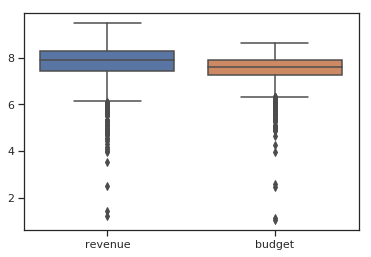

In [445]:
sns.boxplot(data = main_df[['revenue','budget']])
plt.show()

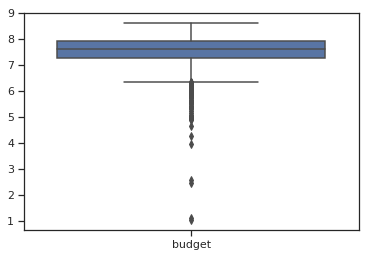

In [446]:
sns.boxplot(data = main_df[['budget']])
plt.show()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


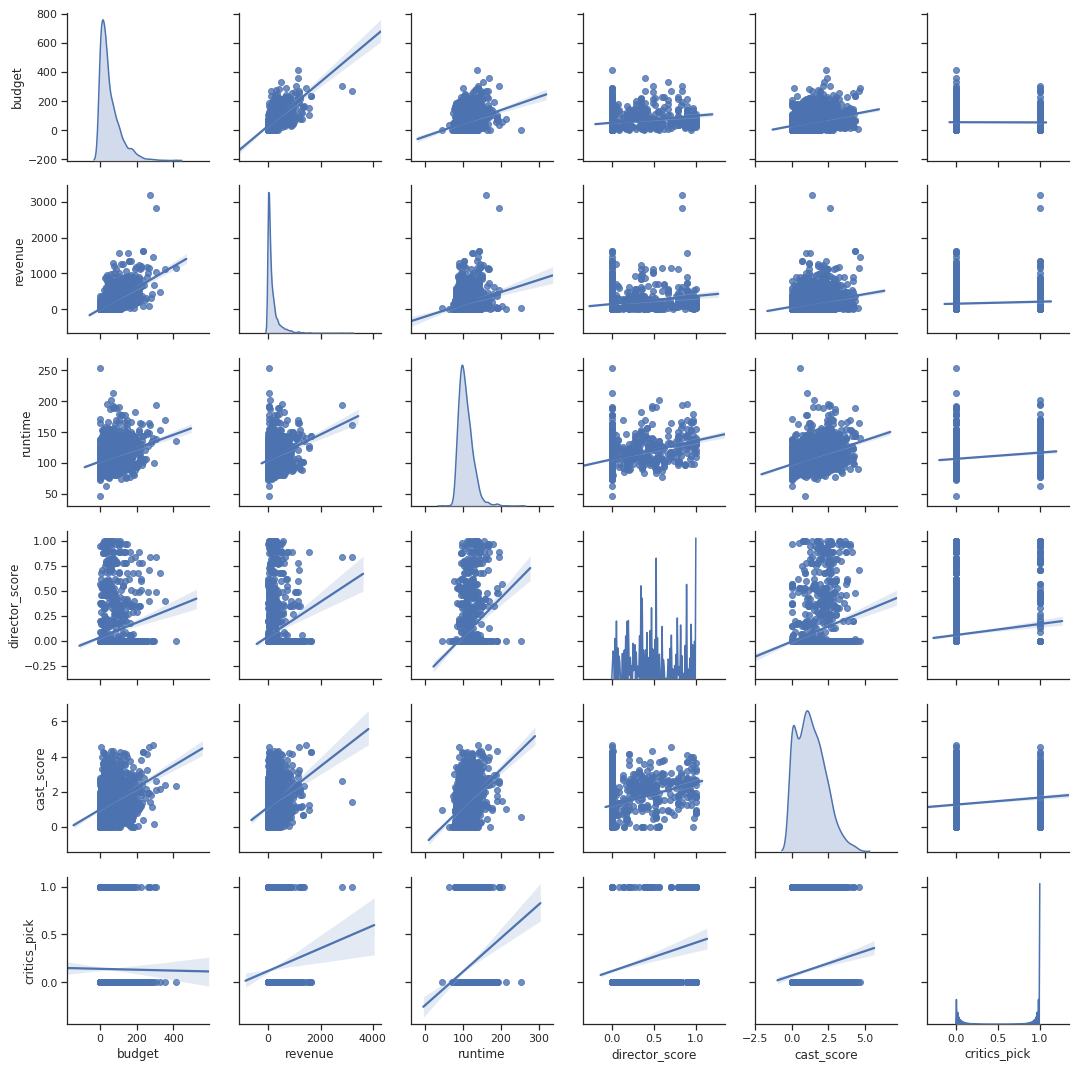

In [9]:
sns.set(style="ticks", color_codes=True)
#plt.scatter(main_df['budget'],main_df['revenue'])
sns.pairplot(main_df[['budget','revenue','runtime','director_score','cast_score','critics_pick']],kind='reg',diag_kind='kde')

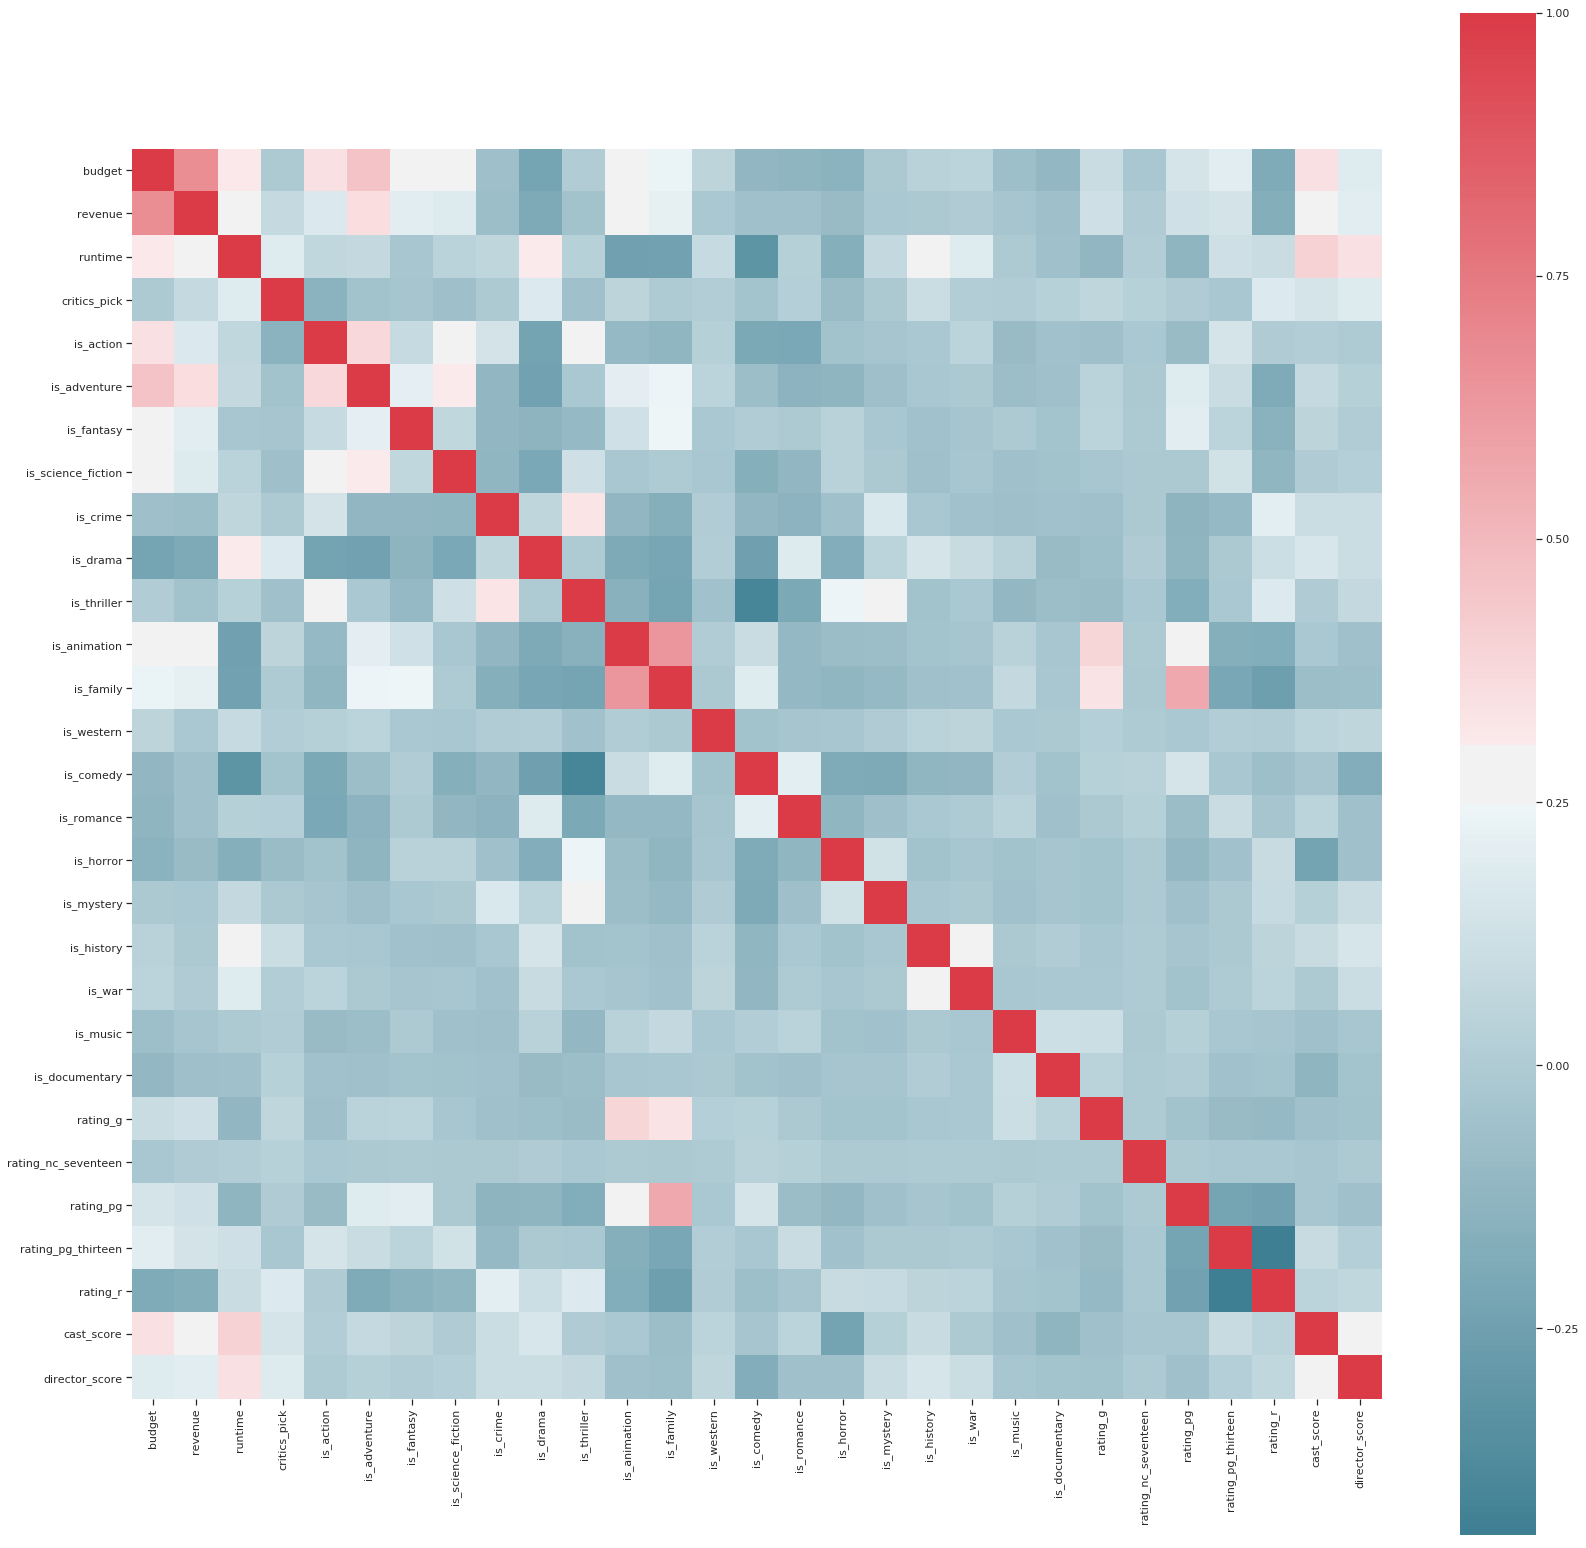

In [10]:
corr = main_df.corr()
plt.figure(figsize = (28,28))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)


                            OLS Regression Results                            
Dep. Variable:     sentiment_polarity   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     20.58
Date:                Sun, 11 Nov 2018   Prob (F-statistic):           6.05e-06
Time:                        19:56:04   Log-Likelihood:                -2696.0
No. Observations:                2093   AIC:                             5396.
Df Residuals:                    2091   BIC:                             5407.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0397      0.021     -1.918   

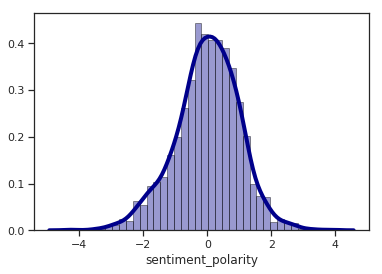

In [368]:
sns.distplot(ny_sentiment_df['sentiment_polarity'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

results = smf.ols('''sentiment_polarity ~ critics_pick''', data=main_df).fit()
print(results.summary())
print(ny_sentiment_df.head())

[Text(0, 0.5, 'distribution'), Text(0.5, 0, 'revenue')]

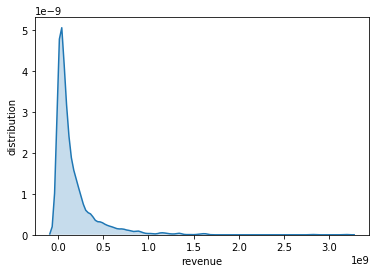

In [39]:
ax = sns.kdeplot(np.power(10,main_df['revenue'].tolist()), shade=True)
ax.set(xlabel='revenue',ylabel='distribution')

[Text(0, 0.5, 'distribution'), Text(0.5, 0, 'budget')]

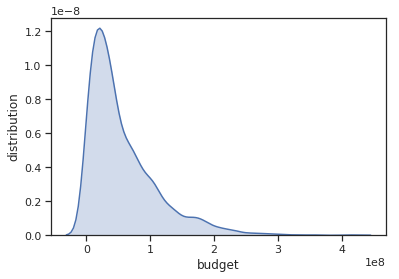

In [461]:
ax = sns.kdeplot(np.power(10,main_df['budget'].tolist()), shade=True)
ax.set(xlabel='budget',ylabel='distribution')

## Modelling

total in test set: 2009
percent with less than 0.2 error: 1238
accuracy: 0.6162269785963166
                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     150.8
Date:                Mon, 12 Nov 2018   Prob (F-statistic):          7.51e-166
Time:                        15:44:16   Log-Likelihood:                -1316.1
No. Observations:                1406   AIC:                             2648.
Df Residuals:                    1398   BIC:                             2690.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------

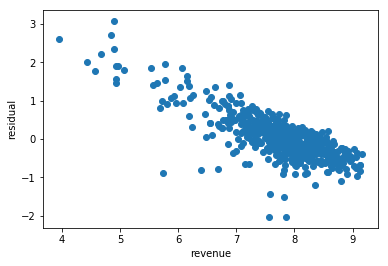

In [11]:
x_df = main_df.drop(columns=['revenue','title'])
x_df.drop(columns=['rating_g' ,'rating_nc_seventeen', 'rating_pg', 'rating_pg_thirteen', 'rating_r'],inplace=True)
y_df = main_df['revenue']
x_train,x_test,y_train,y_test = train_test_split(x_df,y_df,test_size = 0.3,random_state=3)
x_train.head()
ols_train = x_train.copy()
ols_train['revenue'] = y_train
limit = 0.2 #error allowed

#bench mark against just predicting mean
error_rate = (10 ** y_df.mean() - 10 ** y_df)/(10 ** y_df)
print('total in test set: ' +str(len(y_df)))
valid_predictions = np.sum(error_rate < limit)
print('percent with less than {} error: '.format(limit) + str(valid_predictions))
print('accuracy: ' + str(valid_predictions/len(y_df)))

def evaluate_ols_results(results):
    print(results.summary())
    predictions = results.predict(x_test)
    plt.scatter(y_test, predictions - y_test)

    error_rate = (10 **predictions - 10 ** y_test)/(10 **y_test)
    correct_predictions = np.sum(error_rate < limit)
    print(correct_predictions, correct_predictions/len(y_test))
    plt.xlabel('revenue')
    plt.ylabel('residual')
    plt.show()
    
formula = '''revenue ~ runtime + budget + cast_score + director_score + critics_pick + sentiment_polarity + sentiment_polarity * budget'''

results = smf.ols(formula, data=ols_train).fit()
evaluate_ols_results(results)



                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     172.7
Date:                Sun, 11 Nov 2018   Prob (F-statistic):          1.84e-164
Time:                        23:14:01   Log-Likelihood:                -1322.0
No. Observations:                1406   AIC:                             2658.
Df Residuals:                    1399   BIC:                             2695.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.9625      0

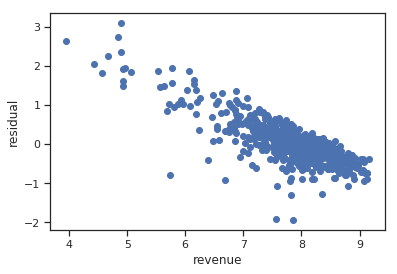

In [519]:
formula1 = '''revenue ~ runtime + critics_pick + budget + cast_score + director_score + sentiment_polarity'''
formula2 = '''revenue ~ sentiment_polarity'''

formula3 = '''revenue ~ 
                    budget + critics_pick + cast_score + director_score
                    + budget * critics_pick + budget * cast_score + budget * director_score
                    + critics_pick * cast_score + critics_pick * director_score
                    + cast_score * director_score
                    + np.power(budget,2) + np.power(critics_pick,2) + np.power(cast_score,2) + np.power(director_score,2)
                    '''

results = smf.ols(formula1, data=ols_train).fit()
evaluate_ols_results(results)

### Non-Linear Models

In [13]:
def evaluate_model(model,X,Y):
    predictions = cross_val_predict(model,X,Y,cv=5) #predictions = model.predict(X)
    plt.scatter(Y, (predictions - Y))
    error_rate = (10 ** predictions - 10 ** Y)/(10 ** Y)
    valid_predictions = np.sum(error_rate < limit)
    print('percent with less than {} error: '.format(limit) + str(valid_predictions/len(Y)))
    plt.xlabel('revenue')
    plt.ylabel('residual')
    plt.show()


score: 0.3875036307119024
percent with less than 0.2 error: 0.633648581383773


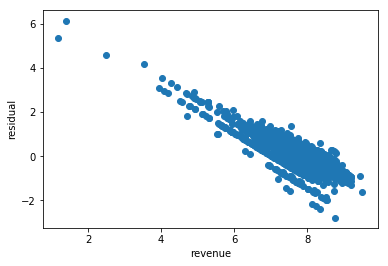

In [23]:
tree_model = DecisionTreeRegressor(max_depth=5)
tree_model.fit(x_train,y_train)
print('score: ' + str(tree_model.score(x_test,y_test)))
evaluate_model(tree_model, x_df,y_df)
tree.export_graphviz(tree_model, out_file='tree.dot',feature_names = x_train.columns) 

score:0.3355910079065233
percent with less than 0.2 error: 0.6142359382777501


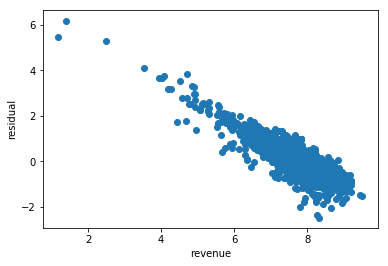

In [28]:
knn_model = KNeighborsRegressor(n_neighbors = 5)
knn_model.fit(x_train,y_train)
print('score:' + str(knn_model.score(x_test,y_test)))
evaluate_model(knn_model, x_df,y_df)

0.14053990279509265
percent with less than 0.2 error: 0.6291687406669985


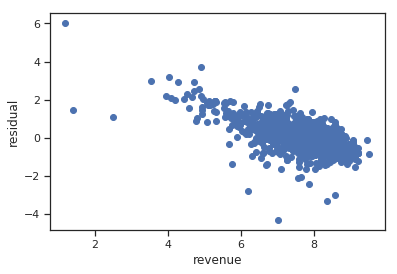

0.21122145499394296
percent with less than 0.2 error: 0.6774514683922349


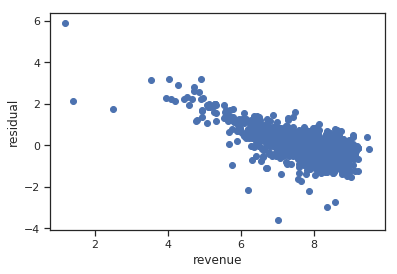

0.3915378710075436
percent with less than 0.2 error: 0.7421602787456446


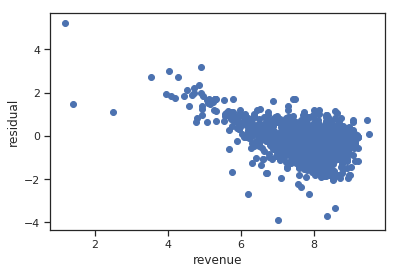

0.15172046785650495
percent with less than 0.2 error: 0.7172722747635639


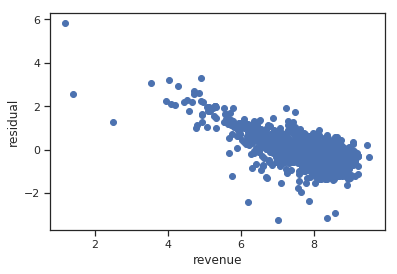

0.3893215408290405
percent with less than 0.2 error: 0.695370831259333


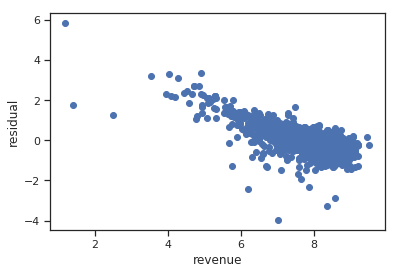

0.4473533452963524
percent with less than 0.2 error: 0.6744649079143853


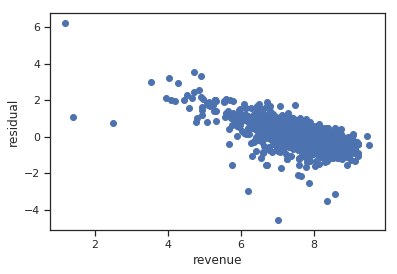

0.190763908492803
percent with less than 0.2 error: 0.6286709805873569


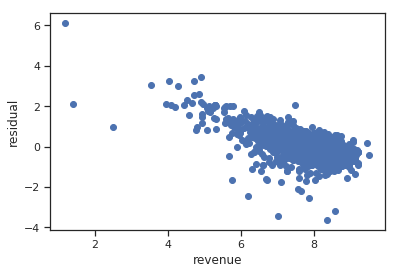

0.46350354591942544
percent with less than 0.2 error: 0.4778496764559482


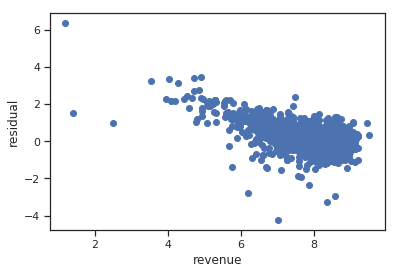

0.45270644133733734
percent with less than 0.2 error: 0.679940268790443


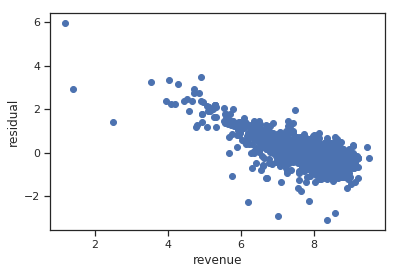

0.4479935107994116
percent with less than 0.2 error: 0.719761075161772


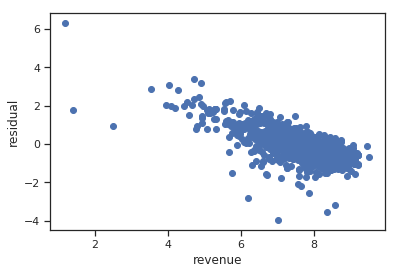

In [518]:
#for a in [10,20,30,40,50,60,70,80]:
for i in range(10):
    a = 60
    mlp_r = MLPRegressor(hidden_layer_sizes=(a,a),max_iter = 2000,learning_rate='invscaling')
    mlp_r.fit(x_train,y_train)
    print(mlp_r.score(x_test,y_test))
    evaluate_model(mlp_r, x_df,y_df)

## Helper functions for scrapping
Functions for retrieving data from NYT movies API and OMDB API. Results are saved in csv files.

In [19]:
#Codes for scraping, dont run. saved to csv file.
NYT_API_KEY = '53223e11b006467490bde835d45b0c74'

all_ny_df = []
for offset in range(0,8000,20):
    url = 'http://api.nytimes.com/svc/movies/v2/reviews/search.json?opening-date=1990-01-01;2016-12-31&offset={0}&api-key=ae71411b586e4f9c82502e7e782b122d'.format(offset)
    ny_json = pd.read_json(url, orient = 'records')
    ny_df = json_normalize(ny_json['results'])
    if ny_df.empty:
        break
    all_ny_df.append(ny_df)

ny_df = pd.concat(all_ny_df)
print(ny_df.tail())
ny_df.to_csv('NY Movie Reviews.csv')


"#Codes for scraping, dont run. saved to csv file.\nNYT_API_KEY = '53223e11b006467490bde835d45b0c74'\n\nall_ny_df = []\nfor offset in range(0,8000,20):\n    url = 'http://api.nytimes.com/svc/movies/v2/reviews/search.json?opening-date=1990-01-01;2016-12-31&offset={0}&api-key=ae71411b586e4f9c82502e7e782b122d'.format(offset)\n    ny_json = pd.read_json(url, orient = 'records')\n    ny_df = json_normalize(ny_json['results'])\n    if ny_df.empty:\n        break\n    all_ny_df.append(ny_df)\n\nny_df = pd.concat(all_ny_df)\nprint(ny_df.tail())\nny_df.to_csv('NY Movie Reviews.csv')"

title = 't=' + nytdata['display_title'][1].replace(' ', '+')
req = 'http://www.omdbapi.com/?apikey='+ OMDB_API_KEY + '&'+ title
print(pd.read_json(req))

In [20]:
OMDB_API_KEY = 'd42886f4'

def fetch_omdb(title):
    title = 't=' + title.replace(' ', '+')
    print (title)
    req = 'http://www.omdbapi.com/?apikey='+ OMDB_API_KEY + '&'+ title
    omdb_df = pd.read_json(req)
    return omdb_df

count = 0
omdb_df_list = []
for title in tmdb_df['title'].tolist():
    count += 1
    omdb_df_list.append(fetch_omdb(title))
    if count > 5:
        break
        
complete = pd.concat(omdb_df_list,axis=0)
complete.to_csv('omdb_data.csv')


"OMDB_API_KEY = 'd42886f4'\n\ndef fetch_omdb(title):\n    title = 't=' + title.replace(' ', '+')\n    print (title)\n    req = 'http://www.omdbapi.com/?apikey='+ OMDB_API_KEY + '&'+ title\n    omdb_df = pd.read_json(req)\n    return omdb_df\n\ncount = 0\nomdb_df_list = []\nfor title in tmdb_df['title'].tolist():\n    count += 1\n    omdb_df_list.append(fetch_omdb(title))\n    if count > 5:\n        break\n        \ncomplete = pd.concat(omdb_df_list,axis=0)\ncomplete.to_csv('omdb_data.csv')\n"

### Sentiment Analysis

#### Scrape NYT critics review article data

In [168]:
import urllib.request
from bs4 import BeautifulSoup
ny_df = pd.read_csv(github_raw_root + 'NY_movie_reviews.csv')


In [169]:
reviews_list = []
title_list = main_df['title'].tolist()

In [173]:
for i in range(0,len(title_list)): #len(title_list)
    title = title_list[i]
    row = ny_df.loc[ny_df['display_title'] == title,['display_title','link.url']]
    if len(row) == 0:
        continue
        
    print(i,title)
    try:
        request = urllib.request.urlopen(row['link.url'].tolist()[0])
    except urllib.error.HTTPError:
        print('http error')
        continue
    #if redirected to movies main, means review cannot be found
    if request.geturl() == 'https://www.nytimes.com/reviews/movies':
        continue
        
    articlebody = None
    page = request.read()   
    soup = BeautifulSoup(page, "html.parser")
    articlebody = soup.find('section', attrs = {'name':'articleBody'})
    
    if articlebody is None:
        articlebody = soup.findAll('p', attrs = {'class':'story-body-text story-content'})
        article =''
        for body in articlebody:
            article += body.get_text()
        reviews_list.append({'title':title,'review_article': article})
           
    else:
        reviews_list.append({'title':title,'review_article': articlebody.get_text()})


612 Yes Man
613 Central Intelligence
614 Daddy's Home
615 Into the Woods
617 Payback
618 Congo
619 We Bought a Zoo
623 Garfield
624 Moneyball
625 Outbreak
626 Race to Witch Mountain
630 Unfaithful
631 I Am Number Four
634 Absolute Power
635 G.I. Jane
636 The Game
637 American Reunion
638 Into the Storm
639 Beverly Hills Cop III
640 Gremlins 2: The New Batch
641 The Judge
642 Out of Time
643 On Deadly Ground
645 Raising Helen
646 Striptease
647 Marmaduke
648 Hereafter
650 The Story of Us
651 The Host
652 The Host
653 Basic
654 Blood Work
656 The Iron Giant
658 Free State of Jones
659 Run All Night
661 Your Highness
662 Mad City
663 Baby's Day Out
664 The Scarlet Letter
665 Fair Game
666 Fair Game
667 Jade
668 Gamer
669 Beautiful Creatures
670 Zoolander 2
671 The Big Bounce
672 Drive Angry
673 The One
674 The One
675 The Adventures of Ford Fairlane
676 The Bone Collector
677 Panic Room
678 Three Kings
679 Bedazzled
680 3:10 to Yuma
681 Out of Sight
682 The Cable Guy
683 Dick Tracy
684 Th

1152 Million Dollar Arm
1153 The Giver
1154 Jeepers Creepers 2
1155 Cradle 2 the Grave
1156 The Hours
1159 August Rush
1160 Elizabeth
1161 The Sitter
1162 The Shawshank Redemption
1163 Kingpin
1164 The Gambler
1165 August: Osage County
1168 He Got Game
1170 Dear John
1171 The Losers
1172 Don't Be Afraid of the Dark
1173 War
1174 Punch-Drunk Love
1177 The Box
1178 The Next Best Thing
1179 My Soul to Take
1180 The Girl Next Door
1181 Maximum Risk
1182 Hot Rod
1184 Draft Day
1185 The Conspirator
1186 The 33
1187 Warrior
1189 Stop-Loss
1190 Brokedown Palace
1191 The Possession
1192 Mrs. Winterbourne
1193 Straw Dogs
1194 The Hoax
1195 The Road
1196 The Road
1197 Tank Girl
1200 Without Limits
1201 Me and Orson Welles
1204 Rocky Balboa
1205 Scream 2
1206 Jane Got a Gun
1207 Think Like a Man Too
1208 Old School
1209 The Fisher King
1210 I Still Know What You Did Last Summer
1211 Return to Me
1212 Zack and Miri Make a Porno
1213 Win a Date with Tad Hamilton!
1215 Ready to Rumble
1216 Play It to

1650 The Fourth Kind
1651 Rushmore
1652 Skyline
1653 Mo' Better Blues
1654 Tremors
1655 The Corruptor
1656 Mud
1658 The Gift
1659 The Gift
1660 Office Space
1661 Drop Dead Gorgeous
1662 Very Bad Things
1663 MacGruber
1665 Seeking a Friend for the End of the World
1666 Cedar Rapids
1667 American History X
1668 The Collection
1669 Bad Words
1670 Black or White
1671 Rescue Dawn
1672 Danny Collins
1675 The Forest
1676 While We're Young
1678 Gun Shy
1681 The Joneses
1688 Adventureland
1690 Next Friday
1691 The Runaways
1692 Set It Off
1693 The Best Man
1694 Sicko
1695 Harold & Kumar Go to White Castle
1696 Boiler Room
1697 Chasing Papi
1698 The Way of the Gun
1699 Igby Goes Down
1700 PCU
1701 Gracie
1703 Princess Kaiulani
1705 Awake
1706 Crazy Heart
1707 Baggage Claim
1708 The DUFF
1709 Glitter
1712 Pulp Fiction
1713 Nightcrawler
1715 Little Miss Sunshine
1716 50/50
1717 That Awkward Moment
1719 Drive Me Crazy
1721 Half Baked
1723 Enough Said
1724 Easy A
1725 The Inkwell
1727 Prom
1729 Show

In [174]:
ny_reviews_df = pd.DataFrame(reviews_list)
ny_reviews_df.head()
ny_reviews_df.to_csv('ny_reviews_artcles.csv')

#### Compute Sentiment Polarity Score

In [197]:
from textblob import TextBlob
ny_review_sentiment_df = pd.read_csv('Datasets/ny_reviews_artcles.csv')
ny_review_sentiment_df.head()


,Unnamed: 0,review_article,title
0,0,With “Avatar” James Cameron has turned one man...,Avatar
1,1,"“The immaterial has become material,” announce...",Pirates of the Caribbean: At World's End
2,2,After seven years and two films that have push...,The Dark Knight Rises
3,3,The cast of “John Carter” includes a bunch of ...,John Carter
4,4,If ever a movie had a case of the blues and th...,Spider-Man 3


In [360]:
def compute_polarity(row):
    blob = TextBlob(row['review_article'])
    return blob.sentiment.polarity

ny_review_sentiment_df['sentiment_polarity'] = ny_review_sentiment_df.apply(compute_polarity,axis=1)
ny_review_sentiment_df[['title','sentiment_polarity']].to_csv('ny_reviews_sentiment.csv')